# **Árvores de Decisão**

Nesse módulo começaremos analisando como treinar, visualizar e fazer predições com árvores de decisão. Depois, vamos examinar o algoritmo CART, ID3 e CHAID usado pelo Scikit-Learn e explicar como regularizar as árvores e utilizá-las para tarefas de regressão e Classificação.

In [86]:
import importlib
import subprocess
import sys

# Lista de pacotes necessários.
# As chaves são os NOMES PARA INSTALAR COM PIP.
# Os valores são os NOMES DOS MÓDULOS PARA IMPORTAR (usado por importlib.import_module).
# Se o nome para pip e o nome para importação forem iguais, o valor pode ser o mesmo da chave.
pacotes_para_verificar_e_instalar = {
    "numpy": "numpy",           # pip install numpy -> import numpy
    "matplotlib": "matplotlib", # pip install matplotlib -> import matplotlib
    "pandas": "pandas",         # pip install pandas -> import pandas
    "scikit-learn": "sklearn",  # pip install scikit-learn -> import sklearn
    "IPython": "IPython",       # pip install IPython -> import IPython
    # Adicione outros pacotes aqui, seguindo o padrão: "nome_pip": "nome_import"
    # Exemplo: "requests": "requests"
}

In [87]:
# Função para instalar pacotes
def instalar_pacote(pacote_pip_nome):
    """
    Instala um pacote Python usando pip.
    pacote_pip_nome: o nome do pacote a ser passado para 'pip install'.
    """
    print(f"Instalando {pacote_pip_nome}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pacote_pip_nome])
        print(f"'{pacote_pip_nome}' instalado com sucesso.")
    except subprocess.CalledProcessError as e:
        print(f"Erro ao instalar '{pacote_pip_nome}': {e}")
        # É uma boa prática sair do script se uma dependência essencial não puder ser instalada.
        sys.exit(1)

# Verifica e instala os pacotes
print("Verificando pacotes necessários...")
for nome_pip, nome_modulo_import in pacotes_para_verificar_e_instalar.items():
    try:
        # Tenta importar o módulo. Se for bem-sucedido, o pacote já está instalado.
        importlib.import_module(nome_modulo_import)
        print(f"O pacote '{nome_pip}' (módulo '{nome_modulo_import}') já está instalado.")
    except ImportError:
        # Se ImportError ocorrer, o pacote não está instalado e precisa ser.
        instalar_pacote(nome_pip)

print("\n---")
print("Todos os pacotes necessários estão instalados e prontos para uso.")
print("---")

Verificando pacotes necessários...
O pacote 'numpy' (módulo 'numpy') já está instalado.
O pacote 'matplotlib' (módulo 'matplotlib') já está instalado.
O pacote 'pandas' (módulo 'pandas') já está instalado.
O pacote 'scikit-learn' (módulo 'sklearn') já está instalado.
O pacote 'IPython' (módulo 'IPython') já está instalado.

---
Todos os pacotes necessários estão instalados e prontos para uso.
---


## **Bibliotecas usadas:**

In [1]:
import os  # Módulo para interagir com o sistema operacional (manipular diretórios, arquivos, etc.)

import numpy as np  # Biblioteca fundamental para computação numérica com arrays e funções matemáticas

import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos e visualizações

import pandas as pd  # Biblioteca para manipulação e análise de dados tabulares (DataFrames)

from matplotlib.colors import ListedColormap  # Para criar mapas de cores personalizados em gráficos

from sklearn.datasets import load_iris  # Função para carregar o dataset Iris, clássico para classificação

from sklearn.model_selection import train_test_split  # Para dividir o dataset em treino e teste

from sklearn.model_selection import StratifiedKFold  # Para realizar validação cruzada estratificada, preservando proporções das classes

from sklearn.base import clone  # Para clonar modelos (útil em validação cruzada manual)

from sklearn.tree import DecisionTreeClassifier  # Modelo de Árvore de Decisão para tarefas de classificação

from IPython.display import Image  # Para exibir imagens em ambientes interativos, como Jupyter Notebooks

from sklearn.tree import plot_tree  # Função para visualizar a árvore de decisão graficamente

from sklearn.tree import DecisionTreeRegressor  # Modelo de Árvore de Decisão para tarefas de regressão

from sklearn import datasets  # Submódulo para carregar diversos datasets de exemplo do scikit-learn

from sklearn.metrics import accuracy_score, mean_squared_error  # Métricas para avaliar desempenho de modelos de classificação e regressão

from sklearn import tree  # Submódulo geral que contém funções e classes relacionadas a árvores de decisão


## Treinando e Visualizando uma Árvore de Decisão

### O Algorítmo de Treinamento **CART**

O **Scikit-Learn** utiliza o algoritmo **CART (Classification and Regression Tree)** para treinar **Árvores de Decisão**, processo também conhecido como "crescimento" das árvores. O funcionamento do algoritmo se baseia, inicialmente, na divisão do **conjunto de treinamento** em dois subconjuntos, utilizando para isso uma única **feature** (denotada como `k`) e um determinado **limiar** (`t`), por exemplo: “comprimento da pétala ≤ 2.45 cm”.

Mas como o algoritmo escolhe a melhor combinação entre `k` e `t`? Ele realiza uma busca exaustiva por todas as possíveis combinações, selecionando aquela que produz os subconjuntos mais **puros**, ou seja, com menor mistura de classes. A pureza desses subconjuntos é ponderada pelo seu tamanho, garantindo que subconjuntos maiores tenham maior influência na decisão. A **função de custo** que o CART tenta minimizar é expressa pela seguinte equação:

$$
J(k, t_k) = \dfrac{m_{esq}}{m}G_{esq} + \dfrac{m_{dir}}{m}G_{dir}
$$


onde:

- `G_esq` e `G_dir` são as medidas de **impureza** dos subconjuntos esquerdo e direito, respectivamente.
- `m_esq` e `m_dir` representam o **número de instâncias** nesses subconjuntos.
- `m` é o número total de instâncias no conjunto antes da divisão.

Após encontrar o melhor par `(k, t)`, o algoritmo **divide** o conjunto de treinamento em dois subconjuntos. Em seguida, ele **repete** o mesmo processo recursivamente: tenta novamente encontrar a melhor divisão para cada subconjunto, e assim por diante, criando sucessivamente **sub-subconjuntos**. Esse processo recursivo continua até que seja atingida uma das seguintes **condições de parada**: 

- a profundidade máxima definida pelo hiperparâmetro `max_depth`, ou 
- a impossibilidade de encontrar uma divisão que reduza a **impureza**.

Além de `max_depth`, o CART possui outros hiperparâmetros importantes que controlam as condições de parada:

- `min_samples_split`: número mínimo de amostras necessário para realizar uma divisão.
- `min_samples_leaf`: número mínimo de amostras que um nó folha deve conter.
- `min_weight_fraction_leaf`: fração mínima do peso total que um nó folha deve ter.
- `max_leaf_nodes`: número máximo de nós folha permitidos na árvore.

> ⚠️ **Importante:**  
> O CART é um **algoritmo guloso** (*greedy*): ele busca avidamente a melhor divisão possível no **nível atual**, e depois repete o processo nos níveis subsequentes, sem considerar se essas escolhas levarão à **melhor solução global** em níveis mais profundos. Embora isso normalmente resulte em uma solução **razoavelmente boa**, ela não é garantidamente a **ótima**.

Infelizmente, encontrar a **árvore ótima** é um problema conhecido como **NP-Completo**, o que significa que a sua resolução requer um tempo exponencial em relação ao número de instâncias, `O(exp(m))`, tornando-o **intratável** mesmo para conjuntos de treinamento de tamanho relativamente pequeno. Por essa razão, aceitamos uma solução que seja **"boa o suficiente"** em vez de buscar a perfeição absoluta.

### Funções de Impureza: Gini, Entropia e MSE

As funções de impureza são **métricas** utilizadas por algoritmos de árvores de decisão para **avaliar a qualidade** de uma divisão (split). A ideia central é: quanto mais “puro” for um subconjunto — ou seja, quanto mais ele contiver apenas uma classe —, melhor é a divisão. Dentre as funções de impureza mais usadas destacam-se a **Impureza de Gini** e a **Entropia** (baseada na Teoria da Informação). Para tarefas de **regressão**, usa-se uma outra métrica: o **Erro Quadrático Médio** (*Mean Squared Error*, MSE).

---

#### ✅ Impureza de Gini

##### **1. Intuição**

A Impureza de Gini mede a **probabilidade** de que uma instância escolhida **aleatoriamente** do conjunto de dados seja **classificada incorretamente** se for rotulada aleatoriamente segundo a **distribuição de classes** no conjunto.

Ou seja, quanto mais **misturadas** estiverem as classes, maior será a impureza. Se todas as instâncias pertencem a uma única classe, a impureza é zero.

---

##### **2. Formulação Matemática**

Dado um conjunto de dados com $K$ classes, a impureza de Gini é definida como:

$$
G = 1 - \sum_{k=1}^K p_k^2
$$

Onde:

- $p_k$ → proporção (probabilidade) das instâncias da classe $k$ no conjunto.

---

##### **3. Como se chega nessa fórmula?**

A ideia é calcular a **probabilidade de erro** ao classificar aleatoriamente segundo a distribuição das classes:

1. A chance de pegar uma instância da classe $k$ é $p_k$.
2. A chance de **não** ser da classe $k$ é $1 - p_k$.
3. O erro esperado, portanto, ao escolher aleatoriamente uma classe, é:

$$
\sum_{k=1}^K p_k(1 - p_k)
$$

4. Expandindo a expressão:

$$
\sum_{k=1}^K (p_k - p_k^2) = \sum_{k=1}^K p_k - \sum_{k=1}^K p_k^2
$$

Mas, como $\sum_{k=1}^K p_k = 1$, temos:

$$
1 - \sum_{k=1}^K p_k^2
$$

Portanto, chegamos à fórmula clássica:

$$
G = 1 - \sum_{k=1}^K p_k^2
$$

---

##### **4. Propriedades Importantes**

- $G = 0$ → Conjunto puro (todas as instâncias são da mesma classe).
- $G$ máximo → quando as classes estão igualmente distribuídas.

Por exemplo, para duas classes com $p = 0.5$, temos:

$$
G = 1 - (0.5^2 + 0.5^2) = 0.5
$$

---

#### ✅ Entropia (Impureza da Informação)

##### **1. Intuição**

A **Entropia** mede o grau de **incerteza** ou **imprevisibilidade** associado à distribuição das classes. Inspirada na Teoria da Informação de Claude Shannon, ela quantifica a **quantidade média de informação** necessária para identificar a classe de uma instância.

Quanto maior a mistura de classes, maior a entropia.

---

##### **2. Formulação Matemática**

Dado um conjunto com $K$ classes, a Entropia $H$ é dada por:

$$
H = -\sum_{k=1}^K p_k \log_2(p_k)
$$

Onde:

- $p_k$ → proporção das instâncias da classe $k$.

---

##### **3. Como se chega nessa fórmula?**

O raciocínio vem da **Teoria da Informação**:

1. A **informação** associada ao evento da classe $k$ é:

$$
I(p_k) = -\log_2(p_k)
$$

Isso significa que quanto mais **improvável** for o evento, maior é a informação obtida ao observá-lo.

2. O valor esperado da informação (ou seja, a média ponderada) é:

$$
\sum_{k=1}^K p_k \cdot I(p_k) = -\sum_{k=1}^K p_k \log_2(p_k)
$$

Portanto, a Entropia é essa **média ponderada**.

---

##### **4. Exemplificação**

Para duas classes balanceadas: $p_1 = 0.5$ e $p_2 = 0.5$:

$$
H = - (0.5 \log_2 0.5 + 0.5 \log_2 0.5) = - (0.5(-1) + 0.5(-1)) = 1
$$

Ou seja, entropia máxima = $1$ bit.

Se o conjunto for puro (ex.: $p_1 = 1$, $p_2 = 0$):

$$
H = - (1 \cdot \log_2 1 + 0 \cdot \log_2 0) = 0
$$

(Nota: $0 \log 0 = 0$ por convenção).

---

#### ✅ Comparação entre Gini e Entropia

| Critério          | Impureza de Gini                          | Entropia                                  |
|-------------------|------------------------------------------|-------------------------------------------|
| Interpretação     | Probabilidade de erro aleatório          | Média da informação necessária            |
| Cálculo           | $1 - \sum p_k^2$                         | $-\sum p_k \log_2(p_k)$                   |
| Complexidade      | Mais simples, computacionalmente leve    | Mais complexa, envolve logaritmos         |
| Aplicação         | Muito usada no CART                      | Usada em ID3, C4.5 e outros algoritmos    |

---

#### ✅ Qual é melhor?

Ambas são muito utilizadas e produzem resultados **similares** na prática. A escolha depende de:

- **Eficiência computacional** → Gini é mais rápida.
- **Interpretação teórica** → Entropia tem uma base mais sólida na Teoria da Informação.

Em implementações como a do **Scikit-Learn**, o padrão é usar a **Impureza de Gini**, mas a **Entropia** pode ser facilmente especificada.

---

#### ✅ Mean Squared Error (MSE)

Para tarefas de **regressão** com árvores de decisão, como a **Decision Tree Regressor**, ao invés de usar Gini ou Entropia, utilizamos o **Erro Quadrático Médio (MSE)** como função de custo.

---

##### **1. Intuição**

O MSE mede a **média dos quadrados dos erros** entre os valores reais e os valores previstos. Quanto **menor** for o MSE, **melhor** a divisão, pois significa que os valores previstos estão mais próximos dos reais.

---

##### **2. Formulação Matemática**

Dado um conjunto $S$ com $n$ instâncias, a função de custo é:

$$
MSE = \dfrac{\sum_{i=1}^n (y_i - \hat{y})^2}{n}
$$

Onde:

- $y_i$ → valor real da $i$-ésima instância.
- $\hat{y}$ → média dos valores no subconjunto $S$.

---

##### **3. Como se chega nessa fórmula?**

1. Para cada instância, calculamos o **erro**: $y_i - \hat{y}$.
2. Elevamos ao **quadrado** para penalizar erros maiores.
3. Calculamos a **média** desses quadrados.

Esse processo minimiza a variância dentro de cada subconjunto criado pela divisão.

---

##### **4. Propriedades Importantes**

- MSE é sempre **não-negativo**.
- O **menor valor possível** do MSE é **zero**, indicando previsão perfeita.
- Muito **sensível a outliers**, pois penaliza fortemente erros grandes.

---

### **5. Uso em Árvores de Regressão**

Ao construir uma **árvore de regressão**, o algoritmo escolhe as divisões que **minimizam o MSE** nos subconjuntos resultantes.

---

### ✅ **Formulação de Géron: Função de Custo do CART para Regressão**

O algoritmo CART busca dividir o conjunto de treinamento de modo a **minimizar** a seguinte função de custo:

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} MSE_{\text{left}} + \frac{m_{\text{right}}}{m} MSE_{\text{right}}
$$

onde:

- $m$ → número total de instâncias no nó.
- $m_{\text{left}}$ → número de instâncias no subconjunto da esquerda.
- $m_{\text{right}}$ → número de instâncias no subconjunto da direita.
- $MSE_{\text{left}}$ → MSE do subconjunto da esquerda.
- $MSE_{\text{right}}$ → MSE do subconjunto da direita.

---

**E o MSE de cada nó é dado por:**

$$
MSE_{\text{node}} = \sum_{i \in \text{node}} \left( \hat{y}_{\text{node}} - y^{(i)} \right)^2
$$

sendo que:

$$
\hat{y}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} y^{(i)}
$$

Ou seja, a divisão ótima é aquela que **minimiza a soma ponderada dos MSEs** dos dois subconjuntos resultantes.

---

#### ✅ Resumo

| Tipo de Problema | Função de Impureza/Custo                   |
|------------------|-------------------------------------------|
| Classificação    | Impureza de Gini ou Entropia              |
| Regressão        | Mean Squared Error (MSE)                  |

### Classificação de Árvore de Decisão

Para entender as Árvore de Decisão, vamos criar uma e dar uma espiada como ela faz as predições. O código a seguir treina um ``DecisionTreeClassifier`` no conjunto de dados da íris:

In [27]:
# Carrega a base de dados Iris como um DataFrame do pandas
iris = load_iris(as_frame=True)

# Seleciona duas características (features) específicas: comprimento e largura da pétala
# Converte para um array numpy com .values para uso no modelo
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values

# Obtém os rótulos/classes das amostras (0, 1 ou 2) para as três espécies de Iris
y_iris = iris.target

#### Critério **GINI**

In [28]:
# Cria um classificador de árvore de decisão com profundidade máxima 2 para evitar overfitting
# Define random_state para garantir que a divisão e resultados sejam reprodutíveis
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

# Treina o classificador com as características X_iris e as classes y_iris
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

O ``plot_tree`` é uma função do ``sklearn.tree`` que permite visualizar diretamente uma árvore de decisão, sem necessidade de ferramentas externas como **Graphviz**.

In [29]:
# Cria a nova pasta, se não existir
output_dir = "figuras"  # nome da pasta
os.makedirs(output_dir, exist_ok=True)  # cria a pasta; não dá erro se já existir

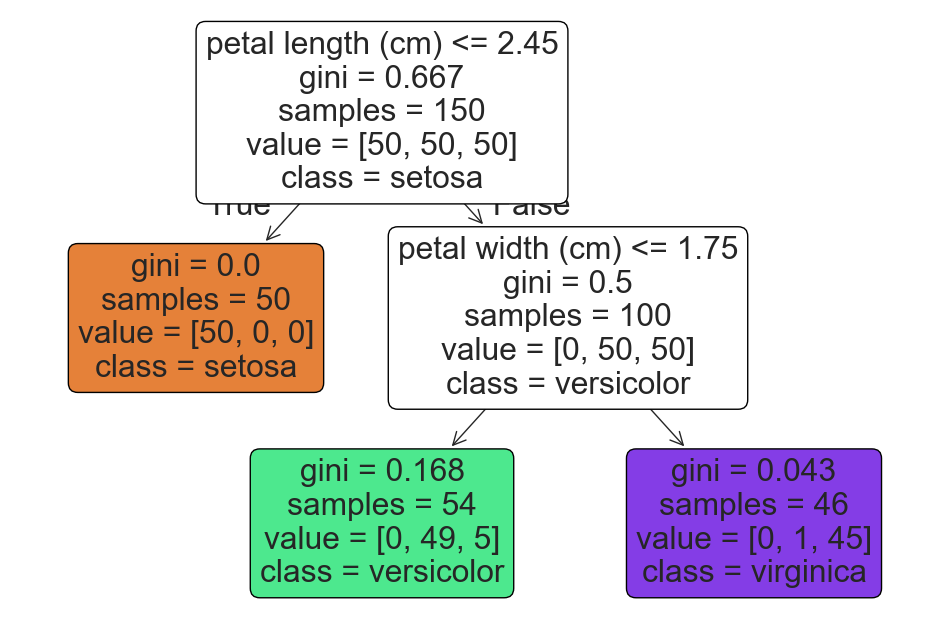

In [30]:
# Cria uma nova figura com tamanho personalizado: largura = 12 polegadas, altura = 8 polegadas
plt.figure(figsize=(12, 8))

# Plota a árvore de decisão treinada (tree_clf)
plot_tree(
    tree_clf,  # modelo de árvore de decisão treinado
    feature_names=["petal length (cm)", "petal width (cm)"],  # nomes das features para exibir nos nós
    class_names=iris.target_names,  # nomes das classes para mostrar nas folhas
    filled=True,  # preenche os nós com cores conforme a classe majoritária
    rounded=True  # bordas arredondadas para melhor estética
)

# Define o caminho completo do arquivo
output_path = os.path.join(output_dir, "decision_tree_plot_1.png")

# Salva a figura no caminho especificado
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibe a figura gerada
plt.show()

#### Critério **ENTROPY (ID3):**

In [37]:
# Cria um classificador de árvore de decisão com profundidade máxima 2 para evitar overfitting
# Define random_state para garantir que a divisão e resultados sejam reprodutíveis
tree_clf_Ent = DecisionTreeClassifier(max_depth=2, random_state=42, criterion='entropy')

# Treina o classificador com as características X_iris e as classes y_iris
tree_clf_Ent.fit(X_iris, y_iris)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

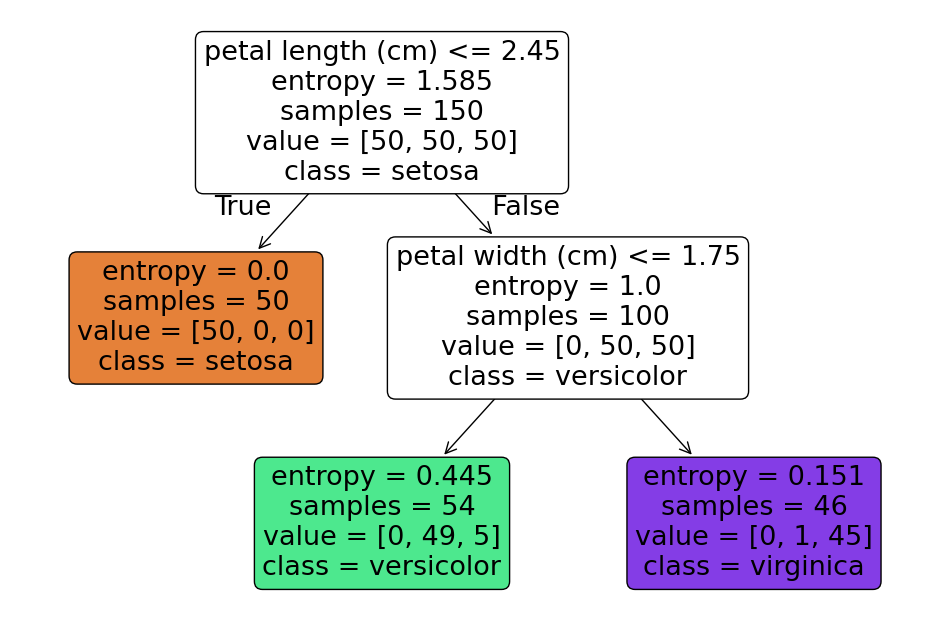

In [46]:
# Cria uma nova figura com tamanho personalizado: largura = 12 polegadas, altura = 8 polegadas
plt.figure(figsize=(12, 8))

# Plota a árvore de decisão treinada (tree_clf)
plot_tree(
    tree_clf_Ent,  # modelo de árvore de decisão treinado
    feature_names=["petal length (cm)", "petal width (cm)"],  # nomes das features para exibir nos nós
    class_names=iris.target_names,  # nomes das classes para mostrar nas folhas
    filled=True,  # preenche os nós com cores conforme a classe majoritária
    rounded=True  # bordas arredondadas para melhor estética
)

# Define o caminho completo do arquivo
output_path = os.path.join(output_dir, "decision_tree_plot_2.png")

# Salva a figura no caminho especificado
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibe a figura gerada
plt.show()

#### **Gráfico de fronteiras de decisão**

Em classificação supervisionada, o modelo aprende a separar classes com base em características (features). A fronteira de decisão é a linha ou superfície que divide o espaço de atributos em regiões, onde cada região corresponde a uma previsão de classe distinta.

No caso das Árvores de Decisão, a fronteira é formada por divisões retangulares e ortogonais (linhas horizontais ou verticais), resultantes das comparações do tipo:

>Se ``feature ≤ threshold`` vai para um lado; senão, vai para outro.

In [49]:
# np.meshgrid cria uma grade de valores para comprimento e largura das pétalas
lengths, widths = np.meshgrid(
    np.linspace(0, 7.2, 100),  # eixo x: de 0 a 7.2 cm com 100 pontos
    np.linspace(0, 3, 100)     # eixo y: de 0 a 3 cm com 100 pontos
)

# Concatena os arrays em uma matriz de shape (10000, 2) — todas as combinações possíveis
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]

# A árvore de decisão (tree_clf) prediz a classe para cada ponto da malha
# Resultado é transformado de volta para o shape da malha (100x100)
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)

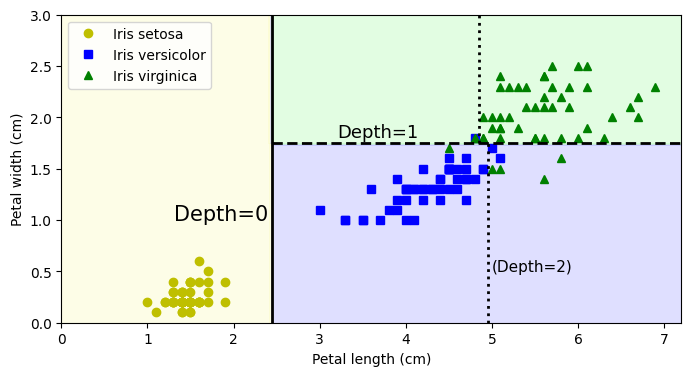

In [50]:
# Criação de colormap personalizado para diferenciar as 3 classes
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

# Define o tamanho da figura: 8 polegadas de largura, 4 de altura
plt.figure(figsize=(8, 4))

# Preenche as regiões conforme a classe prevista
# alpha=0.3 -> transparência para visualizar os pontos reais sobrepostos
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

# Itera sobre as classes de Iris: setosa, versicolor, virginica
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    # Seleciona os pontos pertencentes a cada classe
    plt.plot(
        X_iris[:, 0][y_iris == idx],  # comprimento da pétala
        X_iris[:, 1][y_iris == idx],  # largura da pétala
        style,  # estilo do marcador: y=amarelo, b=azul, g=verde
        label=f"Iris {name}"  # legenda descritiva
    )

# Cria uma árvore com profundidade máxima de 3, para melhor visualização das divisões
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treina a nova árvore no conjunto de dados Iris
tree_clf_deeper.fit(X_iris, y_iris)

# Extrai os thresholds das divisões: índices específicos dos nós da árvore
# Cada threshold corresponde a uma divisão no espaço das features
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]

# Define os rótulos dos eixos
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")

# Primeira divisão: vertical em th0 (profundidade 0)
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)

# Segunda divisão: horizontal em th1 (profundidade 1), da th0 até o fim
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)

# Terceira e quarta divisões: verticais, para refinamento nas regiões
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)

# Adiciona textos indicando a profundidade de cada divisão
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)

# Define os limites dos eixos
plt.axis([0, 7.2, 0, 3])

# Adiciona a legenda com os nomes das classes
plt.legend()

# Define o caminho completo do arquivo
output_path = os.path.join(output_dir, "Fronteira_de_Decisao.png")

# Salva a figura no caminho especificado
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibe o gráfico
plt.show()

O gráfico gerado representa as fronteiras de decisão de uma Árvore de Decisão treinada para classificar amostras de flores Iris com base em duas características:

- Comprimento da pétala (``petal length``)

- Largura da pétala (``petal width``)

**✅ Como funciona a fronteira de decisão:**

- O espaço de atributos (comprimento × largura) é **dividido em regiões** onde cada região corresponde a uma **classe predita** pela árvore.

- As **linhas verticais ou horizontais** representam **limiares (thresholds)** onde a árvore faz uma **divisão (split)**.

- A **primeira divisão** (linha mais grossa) ocorre no nó raiz (profundidade 0), separando os dados com base no **comprimento da pétala = 2.45 cm**:

    - A área à esquerda é pura (apenas Iris-setosa), então não precisa de mais divisões.

    - A área à direita é impura (mistura de Iris-versicolor e Iris-virginica), então ocorre uma nova divisão.

- O segundo split ocorre em **largura da pétala = 1.75 cm** (linha tracejada), que separa ainda mais os dados.

- Como o ``max_depth`` foi configurado para 2, a árvore para nesse ponto.
Se configurássemos ``max_depth=3``, mais duas subdivisões ocorreriam, adicionando novas linhas pontilhadas.

#### Estimando Classe de Probabilidades

Uma Árvore de Decisão também pode estimar a probabilidade de uma instância pertencer a uma determinada classe $ k $. Para isso, a árvore percorre seus nós até encontrar a folha correspondente àquela instância. Em seguida, ela retorna a proporção de instâncias de treinamento daquela classe $ k $ presentes nessa folha. Por exemplo, suponha que você tenha uma flor cujas pétalas medem 5 cm de comprimento e 1,5 cm de largura. A folha encontrada ao percorrer a árvore é a folha à esquerda no nível de profundidade 2. Nesse caso, a árvore de decisão deve fornecer as seguintes probabilidades: 0% para Iris setosa (0 de 54 instâncias nessa folha), 90,7% para Iris versicolor (49 de 54 instâncias) e 9,3% para Iris virginica (5 de 54 instâncias). Ao pedir uma predição de classe, o modelo deve retornar Iris versicolor (classe 1), pois é a classe com maior probabilidade. Vamos verificar isso.

In [61]:
# Usamos o método predict_proba para obter as probabilidades previstas pelo classificador
# para a instância com características [5, 1.5] (pétalas de 5 cm e 1,5 cm de largura).
# O método retorna um array com as probabilidades de cada classe para essa instância.
# Usamos .round(3) para arredondar as probabilidades para 3 casas decimais, facilitando a visualização.
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [62]:
# Usamos o método predict para prever a classe da instância com características [5, 1.5].
# O método retorna a classe com a maior probabilidade, ou seja, a previsão final do modelo.
tree_clf.predict([[5, 1.5]])

array([1])

>VAMOS FAZER MANUALMENTE UMA ÁRVORE DE DECISÂO DE CLASSIFICAÇÂO

| ID | F1 | F2 | F3 | Classe |
| -- | -- | -- | -- | ------ |
| 1  | 2  | 7  | 5  | A      |
| 2  | 3  | 6  | 5  | A      |
| 3  | 4  | 8  | 7  | B      |
| 4  | 5  | 7  | 8  | B      |
| 5  | 6  | 9  | 9  | B      |
| 6  | 7  | 6  | 8  | C      |
| 7  | 8  | 5  | 7  | C      |
| 8  | 9  | 4  | 6  | C      |

### Regressão de Árvore de Decisão

As **Árvores de Decisão** também são capazes de realizar **tarefas de regressão**. Diferente das árvores de classificação, que predizem rótulos discretos, as árvores de regressão predizem **valores numéricos** minimizando uma função de custo como o **Erro Quadrático Médio (MSE - Mean Squared Error)**.

Vamos construir uma **árvore de regressão** usando a classe `DecisionTreeRegressor` do **Scikit-Learn**. Iremos treiná-la em um **conjunto de dados quadrático com ruído** e limitar a profundidade da árvore a **2**, para facilitar a visualização.

In [ ]:
# Definimos uma semente aleatória para garantir a reprodutibilidade dos resultados.
# Isso significa que, sempre que rodarmos o código, obteremos os mesmos números aleatórios.
np.random.seed(42)

# Criamos a variável X_quad com 200 observações aleatórias.
# np.random.rand(200, 1) → gera 200 valores entre 0 e 1.
# Subtraímos 0.5 para centralizar os dados entre -0.5 e +0.5.
X_quad = np.random.rand(200, 1) - 0.5  

# Agora criamos a variável dependente y_quad.
# A relação entre X e y será quadrática: X_quad ** 2 → eleva cada valor ao quadrado.
# Adicionamos também um ruído aleatório com distribuição normal (Gaussiana).
# np.random.randn(200, 1) → gera 200 valores de ruído padrão com média 0 e variância 1.
# Multiplicamos o ruído por 0.025 para que ele seja pequeno, simulando incerteza ou variação nos dados.
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

In [54]:
# Criamos o modelo de Árvore de Decisão para Regressão.
# A classe DecisionTreeRegressor é usada para prever variáveis contínuas (regressão), ao contrário da DecisionTreeClassifier, usada para classificação.

tree_reg = DecisionTreeRegressor(
    max_depth=2,       # Parâmetro que limita a profundidade máxima da árvore.
                      # Neste caso, a árvore terá no máximo dois níveis de splits.
                      # Isso evita o overfitting e garante uma estrutura mais simples e interpretável.

    random_state=42   # Define uma semente para garantir que a construção da árvore seja reprodutível.
                      # Como existem empates ou aleatoriedade na escolha dos splits, isso garante sempre o mesmo resultado.
)

# Agora ajustamos o modelo aos dados.
# O método fit realiza o treinamento: a árvore encontra os melhores pontos de divisão (splits) 
# nos dados, de forma a minimizar o erro quadrático médio (MSE) em cada divisão.

tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

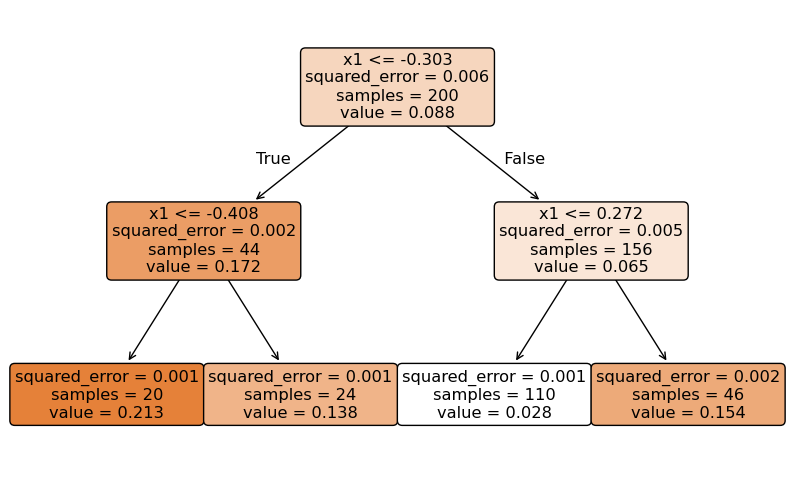

In [55]:
# Criamos uma figura com tamanho maior para que a árvore fique legível.
plt.figure(figsize=(10, 6))

# Usamos a função plot_tree para desenhar a árvore de decisão treinada.
plot_tree(
    tree_reg,            # O modelo de árvore de decisão já treinado.
    feature_names=["x1"],# O nome da variável de entrada, que será exibido nos nós da árvore.
    rounded=True,        # Deixa os cantos das caixas arredondados para uma visualização mais estética.
    filled=True,         # Preenche os nós com cores representando a escala dos valores previstos.
    impurity=True,       # Mostra a impureza (MSE) de cada nó.
    precision=3          # Define a quantidade de casas decimais exibidas nos valores.
)

# Define o caminho completo do arquivo
output_path = os.path.join(output_dir, "decision_tree_plot_3.png")

# Salva a figura no caminho especificado
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibimos o gráfico na tela.
plt.show()

Esta árvore de regressão é muito semelhante à árvore de classificação que vimos anteriormente, mas há uma diferença essencial: em vez de prever uma classe em cada nó, ela prevê um valor numérico. Por exemplo, suponha que desejamos fazer uma previsão para uma nova instância com `x = 0.6`. O processo de predição ocorre percorrendo a árvore a partir do nó raiz, seguindo os ramos conforme as condições estabelecidas (como `x <= valor` ou `x > valor`), até alcançar um nó folha. Quando isso acontece, a árvore retorna um valor numérico — no exemplo citado, esse valor seria `0.154`.

Esse valor representa a média dos valores alvo (`y`) das 110 instâncias de treinamento que também seguiram esse mesmo caminho na árvore e chegaram a essa folha. Além disso, essa previsão está associada a um erro quadrático médio (MSE) de `0.002`, o que significa que, para essas 110 amostras, a média dos quadrados das diferenças entre os valores reais e o valor previsto é relativamente baixa, indicando uma boa qualidade de ajuste naquele subconjunto de dados.

Em resumo, a árvore de regressão funciona agrupando os dados em subconjuntos que sejam internamente homogêneos em relação ao valor da variável dependente, e para cada grupo, faz a previsão utilizando a média das respostas observadas. A profundidade da árvore controla o nível de detalhe dessas divisões: árvores mais profundas criam grupos mais específicos, podendo melhorar a precisão, mas também aumentando o risco de *overfitting*, ou seja, de ajustar-se demais aos dados de treinamento e perder capacidade de generalização.

#### Threshold

Primeiramente, criamos um novo modelo de Árvore de Decisão para Regressão (`DecisionTreeRegressor`) com `max_depth=3`. Isso significa que a árvore poderá ter até três níveis de divisão, o que potencialmente permite capturar padrões mais complexos nos dados. A definição do `random_state=42` garante a reprodutibilidade dos resultados.

In [57]:
# Criamos um novo modelo de Árvore de Decisão para Regressão.
# Aqui definimos a profundidade máxima da árvore como 3.
# Isso significa que ela pode realizar até 3 divisões (ou níveis) para ajustar melhor o modelo aos dados.
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)

Em seguida, treinamos esse modelo com os mesmos dados quadráticos utilizados anteriormente (``X_quad`` e ``y_quad``). O método ``fit()`` é responsável por ajustar o modelo aos dados, ou seja, construir a estrutura da árvore de decisão baseada nesses dados.

In [58]:
# Treinamos o modelo utilizando os mesmos dados quadráticos gerados anteriormente.
# O modelo aprende a partir desses dados e constrói a árvore com base neles.
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

Após o treinamento, podemos inspecionar a estrutura interna da árvore acessando o atributo ``tree_``. Mais especificamente, o atributo ``threshold`` armazena os valores de divisão que foram aprendidos em cada nó interno da árvore. Esses limiares determinam como o espaço de entrada foi particionado.

In [59]:
# Acessamos os limiares (thresholds) dos nós internos da árvore original (tree_reg).
# O atributo 'tree_' contém a estrutura interna da árvore após o treinamento,
# e 'threshold' mostra os valores das condições de divisão em cada nó.
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

Também podemos verificar os limiares para a nova árvore treinada com profundidade 3, usando o mesmo atributo. Comparar os ``thresholds`` de árvores com diferentes profundidades é uma maneira interessante de entender como a complexidade do modelo afeta suas divisões e sua capacidade de ajustar-se aos dados.

In [60]:
# Fazemos o mesmo para a segunda árvore (tree_reg2), que possui uma profundidade maior.
# Ao comparar os thresholds das duas árvores, podemos perceber como o aumento da profundidade
# permite que o modelo faça divisões mais refinadas no espaço de atributos.
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

Este modelo tem suas previsões representadas à esquerda na figura abaixo. Se você definir `max_depth=3`, obterá as previsões representadas à direita. Observe como o valor previsto para cada região é sempre a média dos valores alvo (target) das instâncias daquela região. O algoritmo divide cada região de forma a fazer com que a maioria das instâncias de treinamento fiquem o mais próximo possível do valor previsto.

#### Gráfico de Regressão de Árvore de Decisão

In [ ]:
# Função para plotar as previsões de um modelo de regressão baseado em árvore de decisão,
# dentro de um intervalo de valores predefinido.
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    # Cria um array de 500 pontos uniformemente espaçados no intervalo especificado pelos primeiros dois elementos de 'axes'.
    # Esses pontos são usados para visualizar suavemente a linha de previsão do modelo.
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)  # reshape(-1,1) transforma o array em uma matriz coluna de 500 linhas e 1 coluna.
    
    # Usa o modelo de árvore de decisão (tree_reg) previamente treinado para prever os valores de saída (y) 
    # correspondentes a cada um dos pontos x1.
    y_pred = tree_reg.predict(x1)
    
    # Define os limites dos eixos do gráfico: [x_min, x_max, y_min, y_max], conforme passado por parâmetro.
    plt.axis(axes)
    
    # Rotula o eixo x com a notação LaTeX "$x_1$", indicando a variável independente.
    plt.xlabel("$x_1$")
    
    # Plota os pontos de dados reais utilizados no treinamento: X no eixo x e y no eixo y.
    # "b." significa cor azul ("b") e marcador de ponto (".").
    plt.plot(X, y, "b.")
    
    # Plota as previsões do modelo: pontos de x1 no eixo x e y_pred no eixo y.
    # Estilo "r.-" significa linha contínua ("-"), de cor vermelha ("r") e com marcadores de ponto (".").
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")  
    # label é o nome que aparecerá na legenda, usando notação LaTeX para indicar y chapéu (previsão).


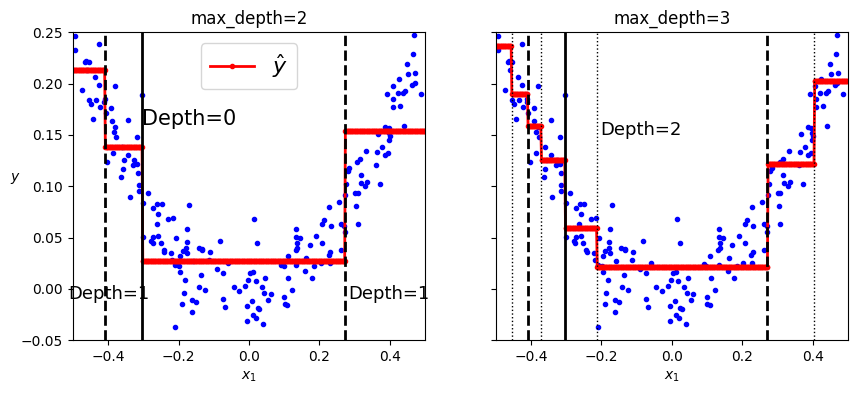

In [ ]:
# Cria uma figura contendo duas subplots (gráficos), organizados lado a lado (ncols=2),
# com um tamanho de 10 por 4 polegadas.
# sharey=True significa que ambos os gráficos compartilham o mesmo eixo y.
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# Seleciona o primeiro eixo (gráfico da esquerda) para que os comandos de plotagem subsequentes
# sejam aplicados a ele.
plt.sca(axes[0])

# Plota as previsões do modelo de árvore de decisão (tree_reg), treinado com profundidade máxima de 2,
# junto com os dados reais, no primeiro gráfico.
plot_regression_predictions(tree_reg, X_quad, y_quad)

# Extrai os valores de threshold (limiares) que a árvore utilizou para realizar as divisões de decisão
# nos nós de profundidade 0 (raiz) e profundidade 1.
# O atributo 'tree_' representa a estrutura interna da árvore, e 'threshold' armazena os valores de corte.
# Aqui pegamos os thresholds dos nós com índices 0 (raiz), 1 e 4.
th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]

# Para cada limiar obtido, plota uma linha vertical no gráfico para visualizar onde a árvore fez a divisão:
# - 'k-' significa linha preta ("k" de "black"), estilo sólido.
# - 'k--' significa linha preta com estilo tracejado.
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    # Cada linha é desenhada de (split, y_min) até (split, y_max).
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)

# Insere textos explicativos no gráfico, próximos aos limiares.
# Indica a profundidade da divisão da árvore.
plt.text(th0, 0.16, "Depth=0", fontsize=15)  # Texto para a raiz (profundidade 0)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)  # Ajuste horizontal para clareza.
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)

# Configura o rótulo do eixo y com notação LaTeX, mantendo a rotação vertical padrão desativada (rotation=0).
plt.ylabel("$y$", rotation=0)

# Adiciona uma legenda ao gráfico, posicionada na parte superior central.
plt.legend(loc="upper center", fontsize=16)

# Define o título para o gráfico da esquerda, indicando a profundidade máxima da árvore.
plt.title("max_depth=2")

# Seleciona o segundo eixo (gráfico da direita) para plotagem.
plt.sca(axes[1])

# Extrai os thresholds correspondentes às divisões adicionais feitas pelo modelo com maior profundidade.
# Aqui usamos a árvore tree_reg2, treinada com max_depth=3.
# São extraídos os thresholds dos nós de índices 2, 5, 9 e 12, que correspondem a divisões adicionais.
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]

# Plota as previsões do modelo tree_reg2 (mais profundo) e os dados reais no segundo gráfico.
plot_regression_predictions(tree_reg2, X_quad, y_quad)

# Plota novamente as mesmas divisões feitas pelo modelo anterior (com max_depth=2), 
# para efeito de comparação visual.
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)

# Plota as novas divisões realizadas pelo modelo mais profundo.
# Estilo "k:" significa linha preta ("k") com estilo pontilhado (":").
# linewidth=1 significa uma linha mais fina.
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)

# Adiciona texto explicativo indicando uma das divisões feitas na profundidade 2.
# Isso ilustra que o modelo mais profundo realiza divisões adicionais.
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)

# Define o título do segundo gráfico, indicando a maior profundidade utilizada.
plt.title("max_depth=3")

# Define o caminho completo do arquivo de saída, utilizando o diretório especificado por output_dir,
# e nomeando o arquivo como "grafico_regress_tree.png".
output_path = os.path.join(output_dir, "grafico_regress_tree.png")

# Salva a figura contendo os dois gráficos no caminho especificado.
# dpi=300 garante alta resolução.
# bbox_inches='tight' remove espaços em branco desnecessários ao redor da figura.
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibe a figura na tela com os dois gráficos lado a lado.
plt.show()

>✅ **O que o gráfico mostra:**

- Eixo X (x₁): variável de entrada.

- Eixo Y (y): variável de saída (observada e prevista).

- Pontos azuis: dados observados.

- Linha vermelha (ŷ): previsão do modelo — valores constantes por regiões.

- Linhas verticais: divisões feitas pela árvore:

    - Sólida: raiz (profundidade 0).

    - Tracejadas: profundidade 1.

    - Pontilhadas: profundidade 2 (somente no segundo gráfico).

>✅ **Primeiro gráfico (esquerda, max_depth = 2):**
A árvore divide os dados em até 3 regiões: uma divisão principal e duas subsequentes. O modelo prevê valores constantes em cada região, gerando uma linha "em degraus". É uma aproximação simples, com baixo risco de overfitting, mas possível underfitting.

>✅ **Segundo gráfico (direita, max_depth = 3):**
Com mais profundidade, a árvore cria divisões adicionais, aumentando os "degraus" e melhorando o ajuste aos dados. A previsão fica mais detalhada, mas há maior risco de overfitting.

>✅ **Interpretação das divisões:**
Cada linha vertical representa uma decisão binária da árvore: "x₁ é menor ou maior que certo limiar?". As divisões mais profundas refinam as previsões, mas aumentam a complexidade e o risco de sobreajuste.

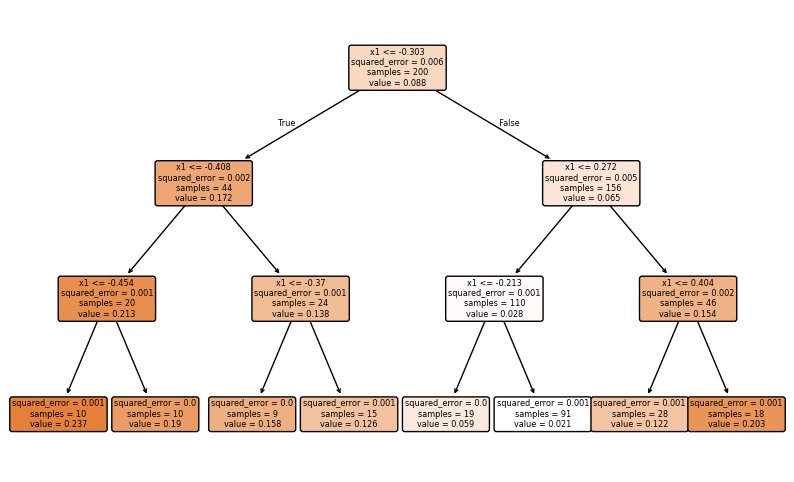

In [65]:
# Criamos uma figura com tamanho maior para que a árvore fique legível.
plt.figure(figsize=(10, 6))

# Usamos a função plot_tree para desenhar a árvore de decisão treinada.
plot_tree(
    tree_reg2,            # O modelo de árvore de decisão já treinado.
    feature_names=["x1"],# O nome da variável de entrada, que será exibido nos nós da árvore.
    rounded=True,        # Deixa os cantos das caixas arredondados para uma visualização mais estética.
    filled=True,         # Preenche os nós com cores representando a escala dos valores previstos.
    impurity=True,       # Mostra a impureza (MSE) de cada nó.
    precision=3          # Define a quantidade de casas decimais exibidas nos valores.
)

# Define o caminho completo do arquivo
output_path = os.path.join(output_dir, "decision_tree_plot_4.png")

# Salva a figura no caminho especificado
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibimos o gráfico na tela.
plt.show()

>VAMOS FAZER MANUALMENTE UMA ÁRVORE DE DECISÂO DE REGRESSÃO

| Instância | x1 | x2 | y  |
| --------- | -- | -- | -- |
| 1         | 1  | 0.2  | 4.5 |
| 2         | 1.5  | 0.4  | 5 |
| 3         | 2  | 0.6  | 5.5 |
| 4         | 2.5  | 0.8  | 6 |
| 5         | 3  | 1  | 6.5 |
| 6         | 3.5  | 1.2  | 7 |

## **Teste e Validação**

### Testando e Validando Modelos

A única forma de saber quão bem um modelo irá generalizar para novos casos é testando-o efetivamente em dados que ele nunca viu antes. Uma maneira é colocar o modelo em produção e monitorar seu desempenho, mas isso pode ser arriscado: se o modelo for muito ruim, os usuários irão reclamar.

Uma abordagem mais segura é dividir os dados em dois conjuntos: **treinamento** e **teste**. Como os nomes indicam, você treina o modelo no conjunto de treinamento e testa seu desempenho no conjunto de teste. O erro que o modelo comete em novos dados é chamado de **erro de generalização** (ou erro fora da amostra). Avaliar o modelo no conjunto de teste fornece uma estimativa desse erro, indicando o quão bem o modelo pode performar em dados inéditos.

Se o erro no conjunto de treinamento for baixo, mas o erro de generalização for alto, isso indica que o modelo está **overfittando** — ou seja, está ajustado demais aos dados de treino e não generaliza bem.

> **Dica:** é comum usar 80% dos dados para treino e reservar 20% para teste. No entanto, isso depende do tamanho do conjunto de dados. Por exemplo, com 10 milhões de instâncias, segurar apenas 1% para teste já fornece uma base grande o suficiente para uma boa estimativa do erro de generalização.

### Ajuste de Hiperparâmetros e Seleção de Modelo

Avaliar um modelo usando apenas o conjunto de teste é simples, mas pode ser insuficiente quando há dúvida entre dois modelos diferentes (por exemplo, um modelo linear e outro polinomial). Uma estratégia é treinar ambos e comparar seu desempenho no conjunto de teste.

Mas e se quisermos ajustar hiperparâmetros, como a regularização, para evitar overfitting? Uma abordagem seria testar várias combinações desses hiperparâmetros e escolher a que apresentar melhor desempenho no conjunto de teste.

Porém, isso pode levar a um problema chamado **vazamento de teste**: ao otimizar hiperparâmetros repetidamente usando o conjunto de teste, o modelo fica "ajustado" para esse conjunto específico, e seu desempenho em dados realmente novos pode ser pior do que o esperado.

### Validação Hold-out

Uma solução para esse problema é a **validação hold-out**: dentro do conjunto de treinamento, reservamos uma parte para validação, chamada de conjunto de **validação** (ou conjunto de desenvolvimento - dev set). Assim, o processo fica assim:

- Treina-se vários modelos com diferentes hiperparâmetros no conjunto de treino reduzido (excluindo o conjunto de validação).
- Avalia-se o desempenho de cada modelo no conjunto de validação.
- Seleciona-se o melhor modelo conforme o desempenho na validação.
- Treina-se o modelo final usando todo o conjunto de treinamento (treino + validação).
- Avalia-se o modelo final no conjunto de teste para estimar o erro de generalização.

Essa técnica geralmente funciona bem, mas há um equilíbrio importante:  
- Se o conjunto de validação for pequeno demais, a avaliação pode ser imprecisa e podemos escolher um modelo subótimo.  
- Se o conjunto de validação for muito grande, o conjunto de treino fica pequeno, e o modelo final pode ficar prejudicado por ter menos dados para aprender.

### Validação K-Fold

Para contornar essas limitações, usa-se a **validação cruzada K-Fold**. Nessa técnica:

- O conjunto de dados é dividido em *K* partes (folds) de tamanho similar.
- O modelo é treinado *K* vezes, cada vez deixando um fold diferente para validação e usando os outros *K-1* folds para treino.
- A performance do modelo é avaliada em cada fold de validação, e a média dessas avaliações dá uma estimativa mais robusta do desempenho.

Assim, conseguimos aproveitar melhor os dados, usando vários conjuntos pequenos de validação, e temos uma medida mais precisa do erro de generalização. A desvantagem é o custo computacional maior, pois o modelo precisa ser treinado *K* vezes.

---

**Resumo:**  
- **Hold-out:** simples, divide o dado em treino, validação e teste. Pode ser instável se os conjuntos forem pequenos.  
- **K-Fold:** usa múltiplas divisões para melhorar a estimativa do desempenho, com maior custo computacional.

---

### **Hold-out Cross-Validation:**

In [2]:
# Carregar a base de dados Iris do scikit-learn
iris = load_iris()
X = iris.data      # Dados de entrada (features) - medidas das flores
y = iris.target    # Rótulos/classes correspondentes (tipo da flor)

# Passo 1: Separar o conjunto de teste (20% dos dados totais)
# train_test_split divide os dados em dois conjuntos:
# - X_train_val, y_train_val: que serão usados para treino e validação
# - X_test, y_test: usados apenas para testar o modelo final
# Parâmetros:
# test_size=0.2 indica que 20% dos dados vão para o teste
# random_state=42 garante que a divisão seja reprodutível (sempre a mesma)
# stratify=y mantém a proporção das classes em ambos conjuntos (estratificação)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Passo 2: Separar treino e validação dentro dos 80% restantes (X_train_val e y_train_val)
# Aqui vamos separar 20% desse conjunto para validação, ou seja,
# 20% dos 80% = 16% do total dos dados
# Isso cria três conjuntos finais:
# - treino: para ajustar o modelo
# - validação: para ajustar hiperparâmetros e selecionar modelos
# - teste: para avaliação final e estimativa do erro de generalização
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

In [3]:
# Exibir os tamanhos dos conjuntos para conferir se a divisão está correta
print(f"Tamanho treino: {X_train.shape[0]} amostras")      # Aproximadamente 64% do total
print(f"Tamanho validação: {X_val.shape[0]} amostras")     # Aproximadamente 16% do total
print(f"Tamanho teste: {X_test.shape[0]} amostras")        # Exatamente 20% do total

Tamanho treino: 96 amostras
Tamanho validação: 24 amostras
Tamanho teste: 30 amostras


### **K-fold Cross-Validation:**

Às vezes, precisamos de mais controle sobre o processo de validação cruzada do que o que o Scikit-Learn oferece pronto para uso. Nesses casos, podemos implementar a validação cruzada manualmente. O código a seguir faz, aproximadamente, a mesma coisa que a função `cross_val_score()` do Scikit-Learn e imprime o mesmo resultado.

In [4]:
# Carregar o dataset Iris (4 atributos, 3 classes)
iris = load_iris()
X = iris.data       # Features (atributos)
y = iris.target     # Rótulos/classes (0,1,2)

# Para simplificar, vamos transformar o problema em binário:
# Detectar se a classe é 0 (setosa) ou não (1)
y_binary = (y == 0).astype(int)

# Instanciar o classificador DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)

In [5]:
# Criar objeto StratifiedKFold para validação cruzada estratificada
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

accuracies = []  # Lista para guardar acurácias de cada fold

# Loop que realiza a validação cruzada manual
for fold, (train_index, test_index) in enumerate(skfolds.split(X, y_binary), 1):
    # Clonar o classificador para treino independente em cada fold
    clone_clf = clone(tree_clf)

    # Separar os dados e rótulos para treino e teste do fold atual
    X_train_folds, X_test_fold = X[train_index], X[test_index]
    y_train_folds, y_test_fold = y_binary[train_index], y_binary[test_index]

    # Treinar o classificador no fold de treino
    clone_clf.fit(X_train_folds, y_train_folds)

    # Fazer a predição no fold de teste
    y_pred = clone_clf.predict(X_test_fold)

    # Calcular a acurácia do fold
    n_correct = np.sum(y_pred == y_test_fold)
    accuracy = n_correct / len(y_pred)

    accuracies.append(accuracy)

    print(f"Fold {fold}: acurácia = {accuracy:.4f}")

Fold 1: acurácia = 1.0000
Fold 2: acurácia = 1.0000
Fold 3: acurácia = 1.0000


In [6]:
print(f"Acurácias dos folds: {accuracies}")
print(f"\nAcurácia média: {np.mean(accuracies):.4f}")

Acurácias dos folds: [1.0, 1.0, 1.0]

Acurácia média: 1.0000


Criamos um pacote que plota os gráficos de Grafo e Fronteira de Decisão, vale mais apena automatizar um pouco do que fazer manualmente. O código a seguir faz isso, mas você pode fazer manualmente se preferir.

In [25]:
import tree_plot
from tree_plot import plot_decision_tree, plot_classification_decision_boundary

In [26]:
help(tree_plot)  # Exibe a documentação do módulo tree_plot

Help on module tree_plot:

NAME
    tree_plot

FUNCTIONS
    plot_classification_decision_boundary(model, X, y, feature_names, class_names=None, output_path=None, figsize=(8, 6), show=True, title='Decision Boundary')
        Plota a fronteira de decisão para problemas de classificação binária ou multiclasse.

        Parâmetros:
        ----------
        model : sklearn DecisionTreeClassifier
            Modelo treinado.

        X : array-like, shape (n_samples, 2)
            Dados de entrada com exatamente 2 features.

        y : array-like, shape (n_samples,)
            Rótulos das classes.

        feature_names : list
            Lista com os nomes das duas features.

        class_names : list, opcional
            Lista com os nomes das classes.

        output_path : str, opcional
            Caminho completo para salvar o gráfico (ex.: './figs/boundary.png').

        figsize : tuple, padrão (8, 6)
            Tamanho da figura.

        show : bool, padrão True
          

In [23]:
# Carregar o dataset Iris (4 atributos, 3 classes)
iris = load_iris()
X = iris.data[:, [0, 1]]  # Pega as features 0 e 1
feature_names = [iris.feature_names[0], iris.feature_names[1]]
y = iris.target     # Rótulos/classes (0,1,2)

# Para simplificar, vamos transformar o problema em binário:
# Detectar se a classe é 0 (setosa) ou não (1)
y_binary = (y == 0).astype(int)

# 🚩 Modelo e Validação Cruzada
tree_clf = DecisionTreeClassifier(random_state=42)
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

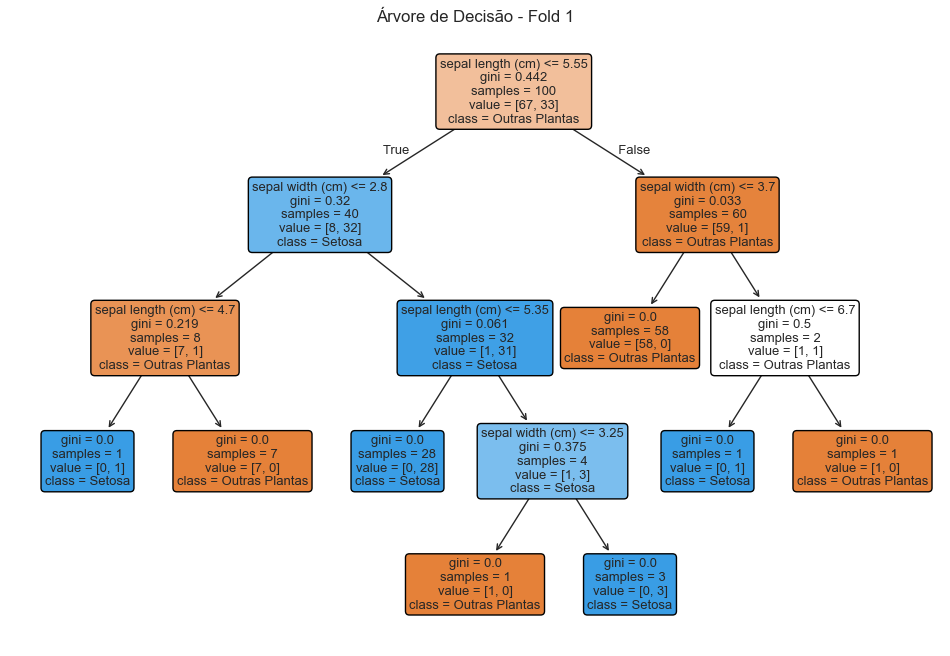

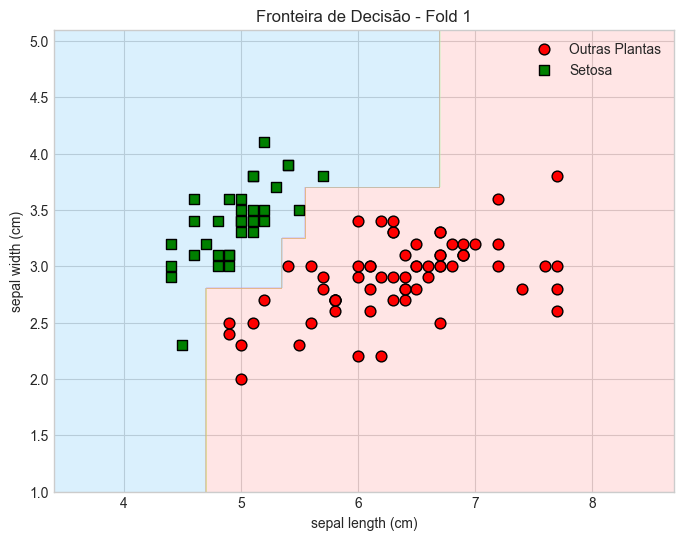

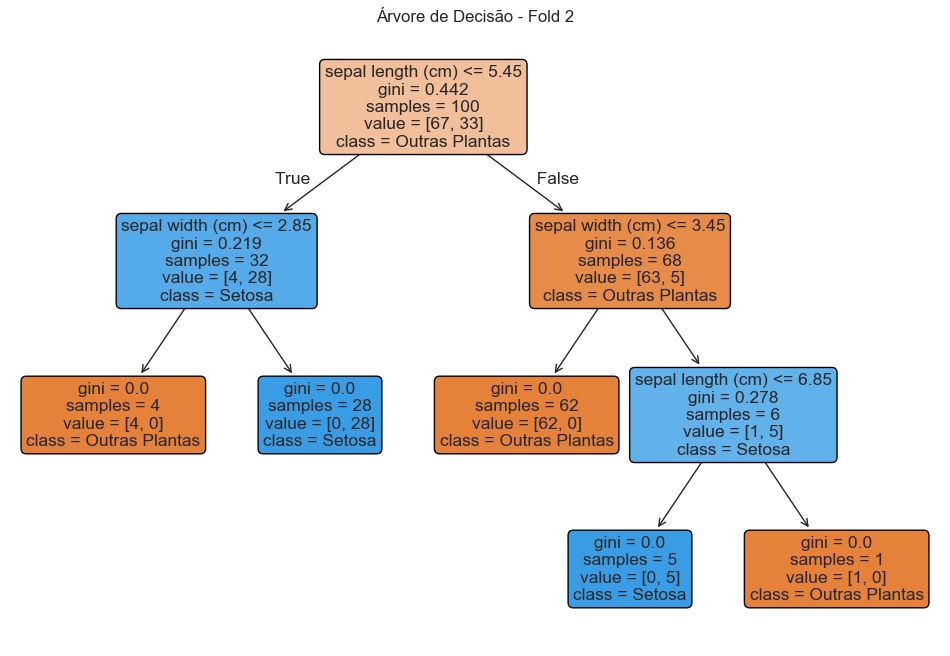

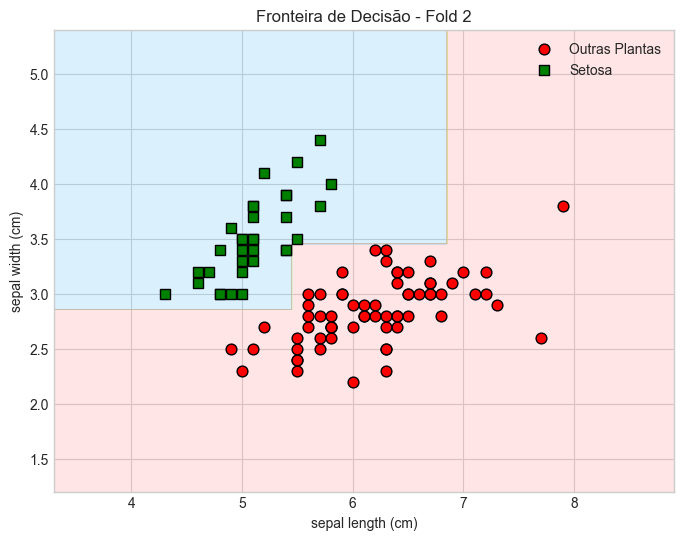

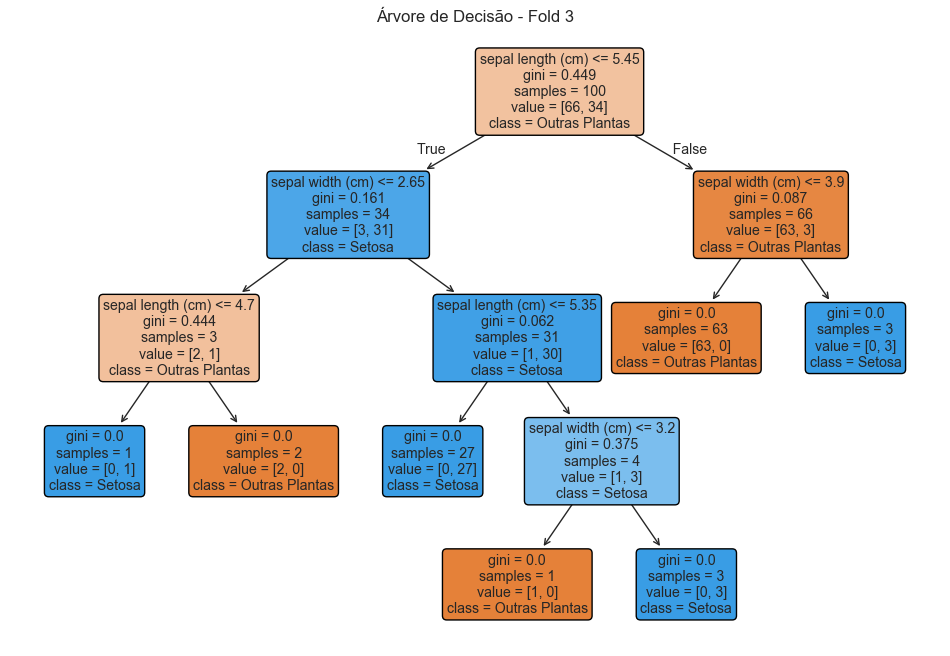

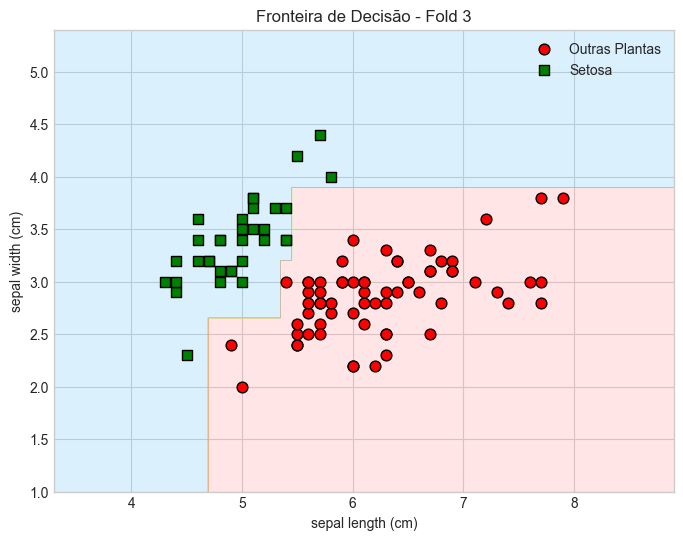

In [ ]:
# Loop que realiza a validação cruzada manualmente utilizando o KFold, iterando sobre os folds gerados.
# A função enumerate é usada para obter o índice do fold (começando em 1 para legibilidade).
for fold, (train_index, test_index) in enumerate(skfolds.split(X, y_binary), 1):

    # Cria uma cópia do classificador de árvore de decisão original para evitar que o treinamento em um fold
    # afete os outros folds. Isso garante que cada modelo seja treinado do zero.
    clone_clf = clone(tree_clf)

    # Separa os dados de treino e teste com base nos índices gerados pelo KFold.
    # X_train_folds: subconjunto de X correspondente ao treino deste fold.
    # X_test_fold: subconjunto de X correspondente ao teste deste fold.
    X_train_folds, X_test_fold = X[train_index], X[test_index]
    
    # Da mesma forma, separa os rótulos (y_binary) em treino e teste.
    y_train_folds, y_test_fold = y_binary[train_index], y_binary[test_index]

    # Treina a cópia do classificador no conjunto de treino deste fold.
    clone_clf.fit(X_train_folds, y_train_folds)

    # 🔥 Plotar o grafo da árvore de decisão treinada neste fold.
    # A função plot_decision_tree recebe:
    # - model: o classificador treinado.
    # - feature_names: nomes das features para rotular os nós da árvore.
    # - class_names: nomes das classes para rotular as folhas.
    # - title: título do gráfico, personalizado com o número do fold.
    # - output_path: None, indicando que não será salvo em arquivo.
    # - show: True, exibindo o gráfico interativamente.
    plot_decision_tree(
        model=clone_clf,
        feature_names=iris.feature_names,  # 🔧 ajuste conforme as features do dataset. Aqui, exemplo com Iris.
        class_names=["Outras Plantas", "Setosa"],  # 🔧 ajuste conforme as classes binárias (ex.: não-Setosa, Setosa).
        title=f"Árvore de Decisão - Fold {fold}",
        output_path=None,
        show=True
    )

    # 🔥 Plotar a fronteira de decisão do classificador treinado neste fold.
    # A função plot_classification_decision_boundary visualiza as regiões de decisão geradas pela árvore.
    # Parâmetros:
    # - model: classificador treinado.
    # - X: dados de entrada (neste caso, os dados de treino deste fold).
    # - y: rótulos correspondentes.
    # - feature_names: nomes das features, para rotular os eixos.
    # - class_names: nomes das classes, para legenda.
    # - title: título específico para o fold atual.
    # - output_path: None, para não salvar o gráfico.
    # - show: True, para exibir o gráfico.
    plot_classification_decision_boundary(
        model=clone_clf,
        X=X_train_folds,  # 🔸 Fronteira de decisão é visualizada com base no conjunto de treino do fold.
        y=y_train_folds,
        feature_names=feature_names,  # 🔧 ajuste conforme as features usadas.
        class_names=["Outras Plantas", "Setosa"],  # 🔧 ajuste conforme os rótulos usados.
        title=f"Fronteira de Decisão - Fold {fold}",
        output_path=None,
        show=True
    )


A classe **StratifiedKFold** realiza uma amostragem estratificada (conforme explicado no antes) para produzir folds que contenham uma proporção representativa de cada classe. Em cada iteração, o código cria uma cópia (clone) do classificador, treina essa cópia nos folds de treinamento e faz previsões no fold de teste. Em seguida, conta o número de previsões corretas e exibe a proporção dessas previsões corretas.

## ATIVIDADE

Como importar os dados:
```python
# 📦 Importando bibliotecas necessárias
from sklearn.datasets import fetch_openml

# ⬇️ Baixando a base de dados Boston Housing do OpenML
boston = fetch_openml(name="Boston", version=1, as_frame=True)

# ⬇️ Baixando a base de dados Boston Housing do OpenML
boston = fetch_openml(name="Boston", version=1, as_frame=True)

# 🗂️ Transformando em DataFrame
X = boston.data        # Dados das variáveis independentes (features)
y = boston.target      # Variável dependente (valor médio das casas)
```

> A base de dados Boston Housing é muito utilizada em problemas de regressão e contém informações sobre diferentes bairros da cidade de Boston (EUA), com o objetivo de prever o valor médio das casas baseado em variáveis socioeconômicas, criminais e estruturais.

| Variável    | Descrição                                                                                  |
| ----------- | ------------------------------------------------------------------------------------------ |
| **CRIM**    | Taxa de criminalidade per capita por bairro.                                               |
| **ZN**      | Proporção de terrenos residenciais destinados a lotes maiores que 25.000 pés quadrados.    |
| **INDUS**   | Proporção de acres de negócios não varejistas por cidade.                                  |
| **CHAS**    | Variável binária: 1 se fizer fronteira com o rio Charles, 0 caso contrário.                |
| **NOX**     | Concentração de óxidos nítricos (poluição do ar).                                          |
| **RM**      | Número médio de quartos por habitação.                                                     |
| **AGE**     | Proporção de unidades ocupadas construídas antes de 1940.                                  |
| **DIS**     | Distâncias ponderadas até cinco centros de negócios de Boston.                             |
| **RAD**     | Índice de acessibilidade às rodovias radiais.                                              |
| **TAX**     | Taxa de imposto sobre propriedade por US\$10.000.                                          |
| **PTRATIO** | Razão de alunos por professor nas escolas da cidade.                                       |
| **B**       | Proporção de afrodescendentes na cidade (cálculo específico: $1000(Bk - 0.63)^2$).         |
| **LSTAT**   | Porcentagem da população de status socioeconômico mais baixo.                              |
| **MEDV**    | Valor médio das casas ocupadas pelos proprietários em milhares de dólares (variável alvo). |


**1) Seleção de Variáveis (Feature Selection)**

Escolha uma técnica de seleção de variáveis, como por exemplo:

- Análise de correlação (selecionar variáveis mais correlacionadas com o alvo).

**2)  Dividir em Treino e Teste**

Divida a base em:

- 70% Treino

- 30% Teste

**3) Construção do Modelo**

Crie um modelo de Árvore de Decisão para Regressão, utilizando:

- Critério: "squared_error"

- Profundidade máxima (max_depth=3).